In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile


In [ ]:
# Setup paths for local execution
import os
import sys

# Project directories
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, 'data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
SRC_DIR = os.path.join(BASE_DIR, 'src')

# Add src to path
sys.path.insert(0, SRC_DIR)


Mounted at /content/drive/


In [3]:
data = pd.read_csv('../../data/cleaned_data.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
original = pd.read_csv('../../data/Data.csv')

In [5]:
counto = original.groupby(['Country','StockCode'])['InvoiceDate'].count().reset_index()

In [6]:
data.drop(['Unnamed: 0'],axis=1,inplace=True)

In [7]:
data = data.sort_values(by=['id_var','ds'])

In [8]:
counto['id_var'] = counto['Country'].astype(str)+'_'+counto['StockCode'].astype(str)

In [9]:
counto = counto.rename(columns={'InvoiceDate':'counto'})

In [10]:
data = data.merge(counto[['id_var','counto']],on=['id_var'],how='left')

In [11]:
data.head()

,id_var,Quantity,cumsum,month,dow,qtr,year,holiday,ds,Country,StockCode,max_date,data_not_available_from,counto
0,Australia_15036,600.0,600.0,5,1,2,2011,0,2011-05-17,Australia,15036,2011-05-17,174,1
1,Australia_15036,0.0,600.0,5,2,2,2011,0,2011-05-18,Australia,15036,2011-05-17,174,1
2,Australia_15036,0.0,600.0,5,3,2,2011,0,2011-05-19,Australia,15036,2011-05-17,174,1
3,Australia_15036,0.0,600.0,5,4,2,2011,0,2011-05-20,Australia,15036,2011-05-17,174,1
4,Australia_15036,0.0,600.0,5,5,2,2011,0,2011-05-21,Australia,15036,2011-05-17,174,1


In [12]:
data.to_csv('../../data/cleaned_data.csv')

In [ ]:
data1 = data.loc[data['counto']>=7,]

In [ ]:
data1.shape

(4671731, 14)

In [ ]:
dat = data1.loc[data1['counto']>=365,]

In [ ]:
dat['id_var'].nunique()

645

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
!pip3 install python-docx

In [ ]:
from docx import Document
from docx.shared import Inches
from docx.shared import Pt
import os
document= Document()
document.add_heading("Country-StockCode-line-plot")

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
lplot = sns.lineplot(data=dat, x="dow", y="Quantity", hue="id_var",ax=ax)
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
lplot.get_figure().savefig("../../outputs/subplot_line_by_week.png")
p = document.add_paragraph('../../outputs/lineplot_Country_Stock_by_week_day'+"\n")
r1 = p.add_run()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
r1.add_picture('../../outputs/subplot_line_by_week.png', width = Inches(7))

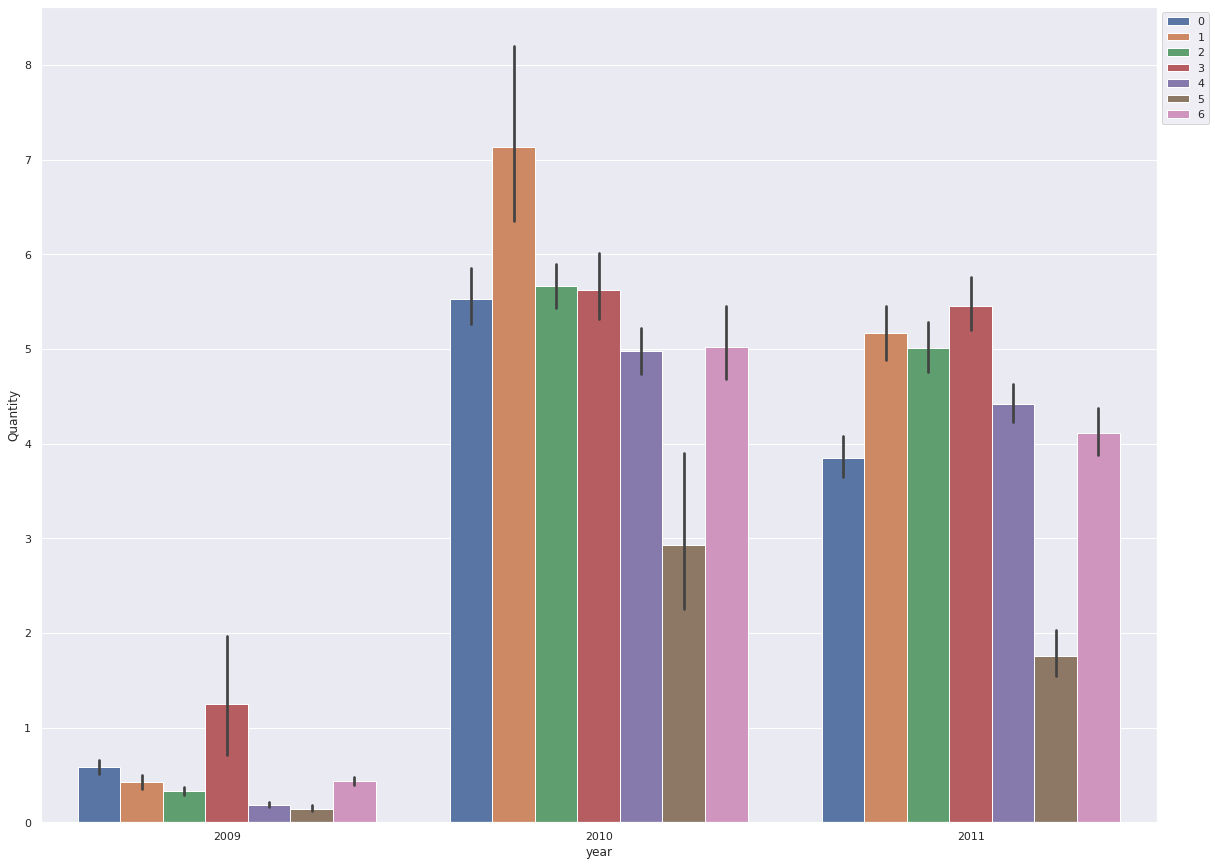

In [ ]:
fig, ax = plt.subplots(figsize=(20,15))
lplot = sns.barplot(data=dat, x="year", y="Quantity", hue="dow",ax=ax)
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
lplot.get_figure().savefig("../../outputs/barplot_line_by_week.png")
p = document.add_paragraph('../../outputs/barplot_Country_Stock_by_week_day'+"\n")
r1 = p.add_run()

In [ ]:
r1.add_picture('../../outputs/barplot_line_by_week.png', width = Inches(7))

Naive seasonal forecast

In [ ]:
validation_week = 8
max_date = pd.to_datetime(data['ds']).max()


In [ ]:
max_date

Timestamp('2011-11-05 00:00:00')

In [ ]:
mx_dt = (max_date - pd.to_timedelta(48, unit='d'))

In [ ]:
data1['ds'] = pd.to_datetime(data1['ds'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train = data1.loc[data1['ds'] <= mx_dt, ]

In [ ]:
val = data1.loc[data1['ds'] > mx_dt,]

In [ ]:
train['forecast'] = train.groupby(['id_var'])['Quantity'].shift(7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train['error'] = np.abs(train['Quantity']-train['forecast'])/(train['Quantity']+1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
error = train.groupby(['id_var'])['error'].mean().reset_index()

In [ ]:
error['error'].mean()

0.802318110569837

In [ ]:
val['lookup_date'] = val['ds'] - pd.to_timedelta(7, unit='d')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
val = val.merge(train[['id_var','ds','Quantity']],left_on=['id_var','lookup_date'],right_on=['id_var','ds'],how='left')

In [ ]:
val = val.rename(columns={'Quantity_y':'forecast','Quantity_x':'Quantity'})

In [ ]:
val.drop(['ds_y'],axis=1,inplace=True)
val = val.rename(columns={'ds_x':'ds'})

In [ ]:
val.shape

(307560, 16)

In [ ]:
val2 = val.loc[val['forecast'].isnull(),]

In [ ]:
val2['forecast'] = val2.groupby(['id_var'])['forecast'].shift(7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
val1 = val.loc[~val['forecast'].isnull(),]

In [ ]:
val = pd.concat([val1,val2],axis=0)
val = val.sort_values(['id_var','ds'])

In [ ]:
val

,id_var,Quantity,cumsum,month,dow,qtr,year,holiday,ds,Country,StockCode,max_date,data_not_available_from,counto,lookup_date,forecast
0,Australia_20685,0.0,62.0,9,0,3,2011,0,2011-09-19,Australia,20685,2011-07-19,111,8,2011-09-12,0.0
1,Australia_20685,0.0,62.0,9,1,3,2011,0,2011-09-20,Australia,20685,2011-07-19,111,8,2011-09-13,0.0
2,Australia_20685,0.0,62.0,9,2,3,2011,0,2011-09-21,Australia,20685,2011-07-19,111,8,2011-09-14,0.0
3,Australia_20685,0.0,62.0,9,3,3,2011,0,2011-09-22,Australia,20685,2011-07-19,111,8,2011-09-15,0.0
4,Australia_20685,0.0,62.0,9,4,3,2011,0,2011-09-23,Australia,20685,2011-07-19,111,8,2011-09-16,0.0


In [ ]:
val['error'] = np.abs(val['Quantity']-val['forecast'])/(val['Quantity']+1)

In [ ]:
verror = val.groupby(['id_var'])['error'].mean().reset_index()

In [ ]:
verror['error'].mean()

0.6338574501619079

In [ ]:
country_stock = val['id_var'].str.split('_',n=1,expand=True)

In [ ]:
val['Country'] = country_stock[0]
val['Stock_Code'] = country_stock[1]

In [ ]:
val['week_start'] = val['ds'].dt.to_period('W-Sun').dt.to_timestamp()

In [ ]:
val_week = val.groupby(['StockCode','week_start'])['Quantity','forecast'].sum().reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [ ]:
val_week['error'] = np.abs(val_week['Quantity']-val_week['forecast'])/(val_week['Quantity']+1)

In [ ]:
verror = val_week.groupby(['StockCode'])['error'].mean().reset_index()

In [ ]:
verror.mean()

error    0.566056
dtype: float64

In [ ]:
val_week.to_csv('../../data/val_week_naive.csv')